In [4]:
from shapely.geometry import Polygon
from model.RegionsCalcs import create_regions
from model.RegionsPlotter import standard_plot, plot_algorithm_result
import numpy as np
from model.NetworkGraph import CompleteGraph
from numpy import random
import matplotlib.pyplot as plt
from tecno_analysis.dimensioning_algorithm_tecnoechonomics import DimensioningAlgorithmTecnoeconomics

In [5]:
# Import the network
graph = CompleteGraph.of_sources("../Passion_Xtreme_III.mat", "../NameTypes.xlsx")

Discarded nodes: 39
Discarded links: 0
Links: 174
Nodes: 154

*-*-* Printing information about the imported network *-*-*

Num nodes: 154
Num links: 174
Num HL4: 20
Num HL5: 134
Average distance: 2.58
Max distance (km): 22.00
Min distance (km): 0.18
Average degree: 2.27
Min degree: 1
Max degree: 10
Average degree HL4: 1.95
Average degree HL5: 2.32
Total bidirectional link length (km): 448.84


In [6]:
graph.network_polygon_bounds

[(0.0, 0.0),
 (0.0, 35.57836559188485),
 (34.593073727138425, 35.57836559188485),
 (34.593073727138425, 0.0),
 (0.0, 0.0)]

In [3]:
num_nodes = len(graph.nodes)
tentative_nodes_for_femtocells = np.zeros(num_nodes, dtype=int)

pick_prob = 0.5
for i, node in enumerate(graph.nodes):
    if node.type == "HL5" and random.random() < pick_prob:
        tentative_nodes_for_femtocells[i] = 1
        
tentative_range_for_femtocells = np.ones(num_nodes)
base_area = graph.network_polygon_bounds
node_power = np.array([0.1 if node.type == "HL5" else 40 for node in graph.nodes])


In [4]:
node_adjacencies_matrix = np.array(graph.adjacency_matrix)
node_positions = np.array([node.pos for node in graph.nodes])
node_type_hl4 = np.array([1 if node.type == "HL4" else 0 for node in graph.nodes])
node_type_hl5 = np.array([1 if node.type == "HL5" else 0 for node in graph.nodes])
traffic_injection = np.array([node.estimated_traffic_injection for node in graph.nodes])
fixed_nodes_for_hpld = node_type_hl4.copy()
tentative_nodes_for_hpld = np.zeros(num_nodes, dtype=int)
tentative_nodes_for_femtocells = node_type_hl5.copy()
tentative_range_for_femtocells = np.ones(num_nodes)
nodes_for_macrocells = node_type_hl4.copy()
range_for_macrocells = np.ones(num_nodes)
alpha_loss = 3
max_runtime_seconds = 180.0
euclidean_to_km_scale = 1.0
power_for_hpld = np.ones(num_nodes) * 5
power_for_femtocells = np.ones(num_nodes) * 0.1
power_for_macrocells = np.ones(num_nodes) * 40
alpha = 0.31
base_area = graph.network_polygon_bounds



In [5]:
algorithm = DimensioningAlgorithmTecnoeconomics(
    node_adjacencies_matrix=node_adjacencies_matrix,
    node_positions=node_positions,
    node_type_hl4=node_type_hl4,
    node_type_hl5=node_type_hl5,
    node_traffic_injection=traffic_injection,
    fixed_nodes_for_hpld=fixed_nodes_for_hpld,
    tentative_nodes_for_hpld=tentative_nodes_for_hpld,
    tentative_nodes_for_femtocells=tentative_nodes_for_femtocells,
    tentative_range_for_femtocells=tentative_range_for_femtocells,
    nodes_for_macrocells=nodes_for_macrocells,
    range_for_macrocells=range_for_macrocells,
    alpha_loss=alpha_loss,
    max_runtime_seconds=max_runtime_seconds,
    euclidean_to_km_scale=euclidean_to_km_scale,
    power_for_hpld=power_for_hpld,
    power_for_femtocells=power_for_femtocells,
    power_for_macrocells=power_for_macrocells,
    base_area=base_area,
    alpha=alpha,
)

In [6]:
nodes_with_hpld, nodes_with_femtocells, hpld_to_femtocell_association, heuristic_1_evolution, heuristic_2_evolution = algorithm.run_algorithm(max_runtime_seconds=max_runtime_seconds)

In [7]:
print(f'Shape of nodes_with_hpld: {nodes_with_hpld.shape}')
print(f'Number of HPLDs: {np.sum(nodes_with_hpld)}')
print(f'Shape of nodes_with_femtocells: {nodes_with_femtocells.shape}')
print(f'Number of femtocells: {np.sum(nodes_with_femtocells)}')
print(f'Shape of hpld_to_femtocell_association: {hpld_to_femtocell_association.shape}')
print(f'Shape of heuristic_1_evolution: {len(heuristic_1_evolution)}')
print(f'Final cost of heuristic_1: {heuristic_1_evolution[-1][1]}')
print(f'Shape of heuristic_2_evolution: {len(heuristic_2_evolution)}')

Shape of nodes_with_hpld: (154,)
Number of HPLDs: 20
Shape of nodes_with_femtocells: (154,)
Number of femtocells: 100
Shape of hpld_to_femtocell_association: (154, 154)
Shape of heuristic_1_evolution: 1163
Final cost of heuristic_1: 51.42139314079439
Shape of heuristic_2_evolution: 0


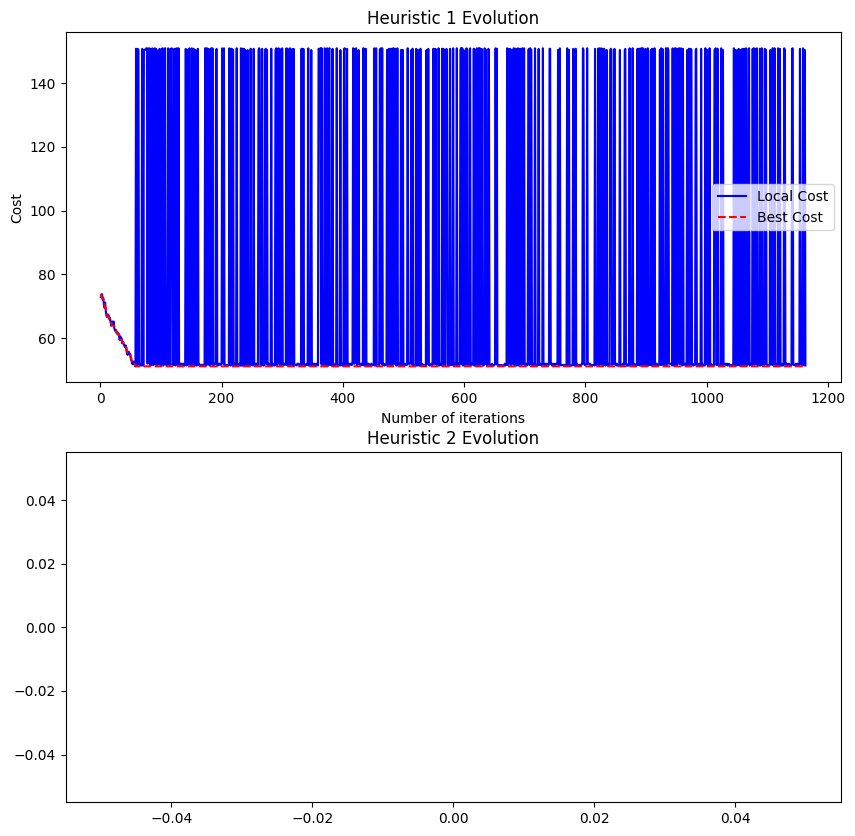

In [8]:
# Printing evolution of the heuristics
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Heuristic 1
# (iteration, cost, best cost, time)
iters = [x[0] for x in heuristic_1_evolution]
costs = [x[1] for x in heuristic_1_evolution]
best_costs = [x[2] for x in heuristic_1_evolution]
times = [x[3] for x in heuristic_1_evolution]


axs[0].plot(iters, costs, label='Local Cost', color='blue', linestyle='-')
axs[0].plot(iters, best_costs, label='Best Cost', color='red', linestyle='--')
axs[0].set_title('Heuristic 1 Evolution')
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('Cost')
axs[0].legend()

# Heuristic 2
# (time, cost, num_iterations)
iters = [x[2] for x in heuristic_2_evolution]
axs[1].plot(heuristic_2_evolution)
axs[1].set_title('Heuristic 2 Evolution')
plt.show()



In [9]:
nodes_with_hpld

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
nodes_with_femtocells

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
hpld_to_femtocell_association

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
node_positions

array([[10.81368257, 33.57836559],
       [16.69026513, 17.61496551],
       [24.85323932, 14.36374894],
       [12.00012644, 10.42867577],
       [22.4564953 , 16.6990066 ],
       [14.99625026, 13.39637459],
       [22.65222109, 22.53048249],
       [17.74017233, 10.05124959],
       [25.51098711, 21.78986516],
       [23.97340452, 18.51306172],
       [27.88509478, 22.19212142],
       [ 9.68725445,  7.17274948],
       [20.10155215, 15.65904674],
       [ 7.40983853, 10.96059539],
       [30.26365018, 15.86387668],
       [18.31915707, 13.10675426],
       [ 3.48321752, 26.51314547],
       [17.22890691, 21.82360317],
       [18.57220737,  4.41188527],
       [20.1352073 , 14.51723008],
       [19.19749114, 16.80840664],
       [ 3.62286201, 15.51776993],
       [15.6841772 , 23.83609916],
       [ 4.32823348, 12.68257803],
       [10.44467001,  8.25684298],
       [20.39782648, 23.55398832],
       [22.79541761, 28.03102833],
       [14.10677013, 18.15691877],
       [11.97724091,

In [13]:
tentative_nodes_for_femtocells

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
tentative_range_for_femtocells

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [15]:
traffic_injection

array([ 250, 1000,  500,  500, 1000, 1000, 1000,  500,  500, 1000,  500,
        250, 1000,  250,  250, 1000,  250, 1000,  250, 1000, 1000,  250,
        500,  250,  250, 1000,  500, 1000,  500,  500,  500,  500,  250,
        250,  250,  250,  250, 1000,  500,  500, 1000,  500,  250,  250,
       1000, 1000, 1000, 1000,  500,  500, 1000, 1000, 1000, 1000,  500,
        500, 1000,  500, 1000,  500,  250, 1000,  250,  500,  250,  500,
        500,  250, 1000,  500,  250,  250,  500,  500,  500, 1000,  500,
       1000, 1000,  500,  500, 1000,  500,  500, 1000,  500,  250,  500,
        500, 1000, 1000, 1000, 1000, 1000,  500,  500, 1000, 1000,  500,
        250,  250,  250, 1000,  250,  250,  250,  250,  250,  250, 1000,
        250,  250,  250, 1000,  250, 1000,  500,  500,  250,  500, 1000,
        500,  250,  500,  250,  250,  500, 1000,  250,  250,  500,  250,
        250,  250,  500,  250, 1000,  250,  500,  250,  250,  250, 1000,
       1000,  250,  500, 1000,  500,  250,  250,  2

In [16]:
node_power

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1, 40. , 40. , 40. , 40. , 40. , 40. , 40. , 40. , 40. ,
       40. , 40. , 40. , 40. , 40. , 40. , 40. , 40

# Associations

In [17]:
from tecno_analysis.dimensioning_algorithm_associations import NodePositionsAlgorithm

In [18]:
assoc_algo = NodePositionsAlgorithm(nodes_with_femtocells, node_adjacencies_matrix, node_type_hl4, np.zeros(len(node_positions)))

In [20]:
base_associations = assoc_algo.determine_best_associations(nodes_with_hpld)

In [22]:
print(base_associations.shape)
print(base_associations.sum())
base_associations

(154, 154)
100


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [43]:
print(f'Num Femtos associated to 1 HPLD: {(np.sum(base_associations, axis=0) == 1).sum()}')
print(f'Num Femtos not associated to HPLD: {(np.sum(base_associations[:, nodes_with_femtocells == 1], axis=0) == 0).sum()}')
print(f'Num HPLDs emtpy: {(np.sum(base_associations[node_type_hl4 == 1, :], axis=1) == 0).sum()}')
print(f'Num HPLDs with > 5 Femtos: {(np.sum(base_associations[node_type_hl4 == 1, :], axis=1) > 5).sum()}')

Num Femtos associated to 1 HPLD: 100
Num Femtos not associated to HPLD: 0
Num HPLDs emtpy: 0
Num HPLDs with > 5 Femtos: 0


# Plot the femtocells

# TODO

In [23]:
# Common scenario for both cases
# Params
p_tx_fem = 10       # W

femotcells = [
    [node_positions[node][0], node_positions[node][1], 0.1] for node in range(num_nodes) if nodes_with_femtocells[node] == 1
]

In [24]:

regions, _unsold = create_regions(
    np.array(femotcells),
    alpha_loss, 
    polygon_bounds=base_area,
)

In [25]:
regions

{99: <POLYGON ((18.508 5.393, 18.447 5.422, 18.447 5.422, 18.362 5.472, 18.362 5....>,
 98: <POLYGON ((4.225 15.021, 4.225 15.021, 4.225 15.021, 4.225 15.021, 4.225 15....>,
 97: <POLYGON ((13.039 22.889, 13.039 22.889, 13.039 22.889, 13.039 22.889, 13.03...>,
 96: <POLYGON ((6.235 27.54, 6.233 27.529, 6.233 27.529, 6.21 27.434, 6.21 27.434...>,
 95: <POLYGON ((13.568 32.733, 13.586 32.713, 13.586 32.713, 13.645 32.634, 13.64...>,
 94: <POLYGON ((19.646 23.058, 19.646 23.058, 19.646 23.058, 19.646 23.058, 19.64...>,
 93: <POLYGON ((15.877 31.764, 15.879 31.762, 15.879 31.762, 15.912 31.67, 15.912...>,
 92: <POLYGON ((22.074 30.347, 22.128 30.344, 22.128 30.344, 22.225 30.33, 22.225...>,
 91: <POLYGON ((11.849 17.806, 11.851 17.82, 11.851 17.82, 11.874 17.915, 11.874 ...>,
 90: <POLYGON ((17.049 16.788, 17.049 16.788, 17.049 16.788, 17.049 16.788, 17.04...>,
 89: <POLYGON ((26.765 25.7, 26.76 25.602, 26.76 25.602, 26.746 25.505, 26.746 25...>,
 88: <POLYGON ((4.231 15.008, 4.231 15.008,

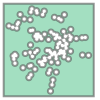

In [26]:
_unsold

In [27]:
area = Polygon(base_area)
print(f'Complete region area:{area.area}')
print(f'Uncovered area:{_unsold.area}')
print(f'Covered area:{area.area - _unsold.area} ({(area.area - _unsold.area) / area.area * 100:.2f}%)')

Complete region area:1230.7650240111575
Uncovered area:981.2973546617195
Covered area:249.46766934943798 (20.27%)


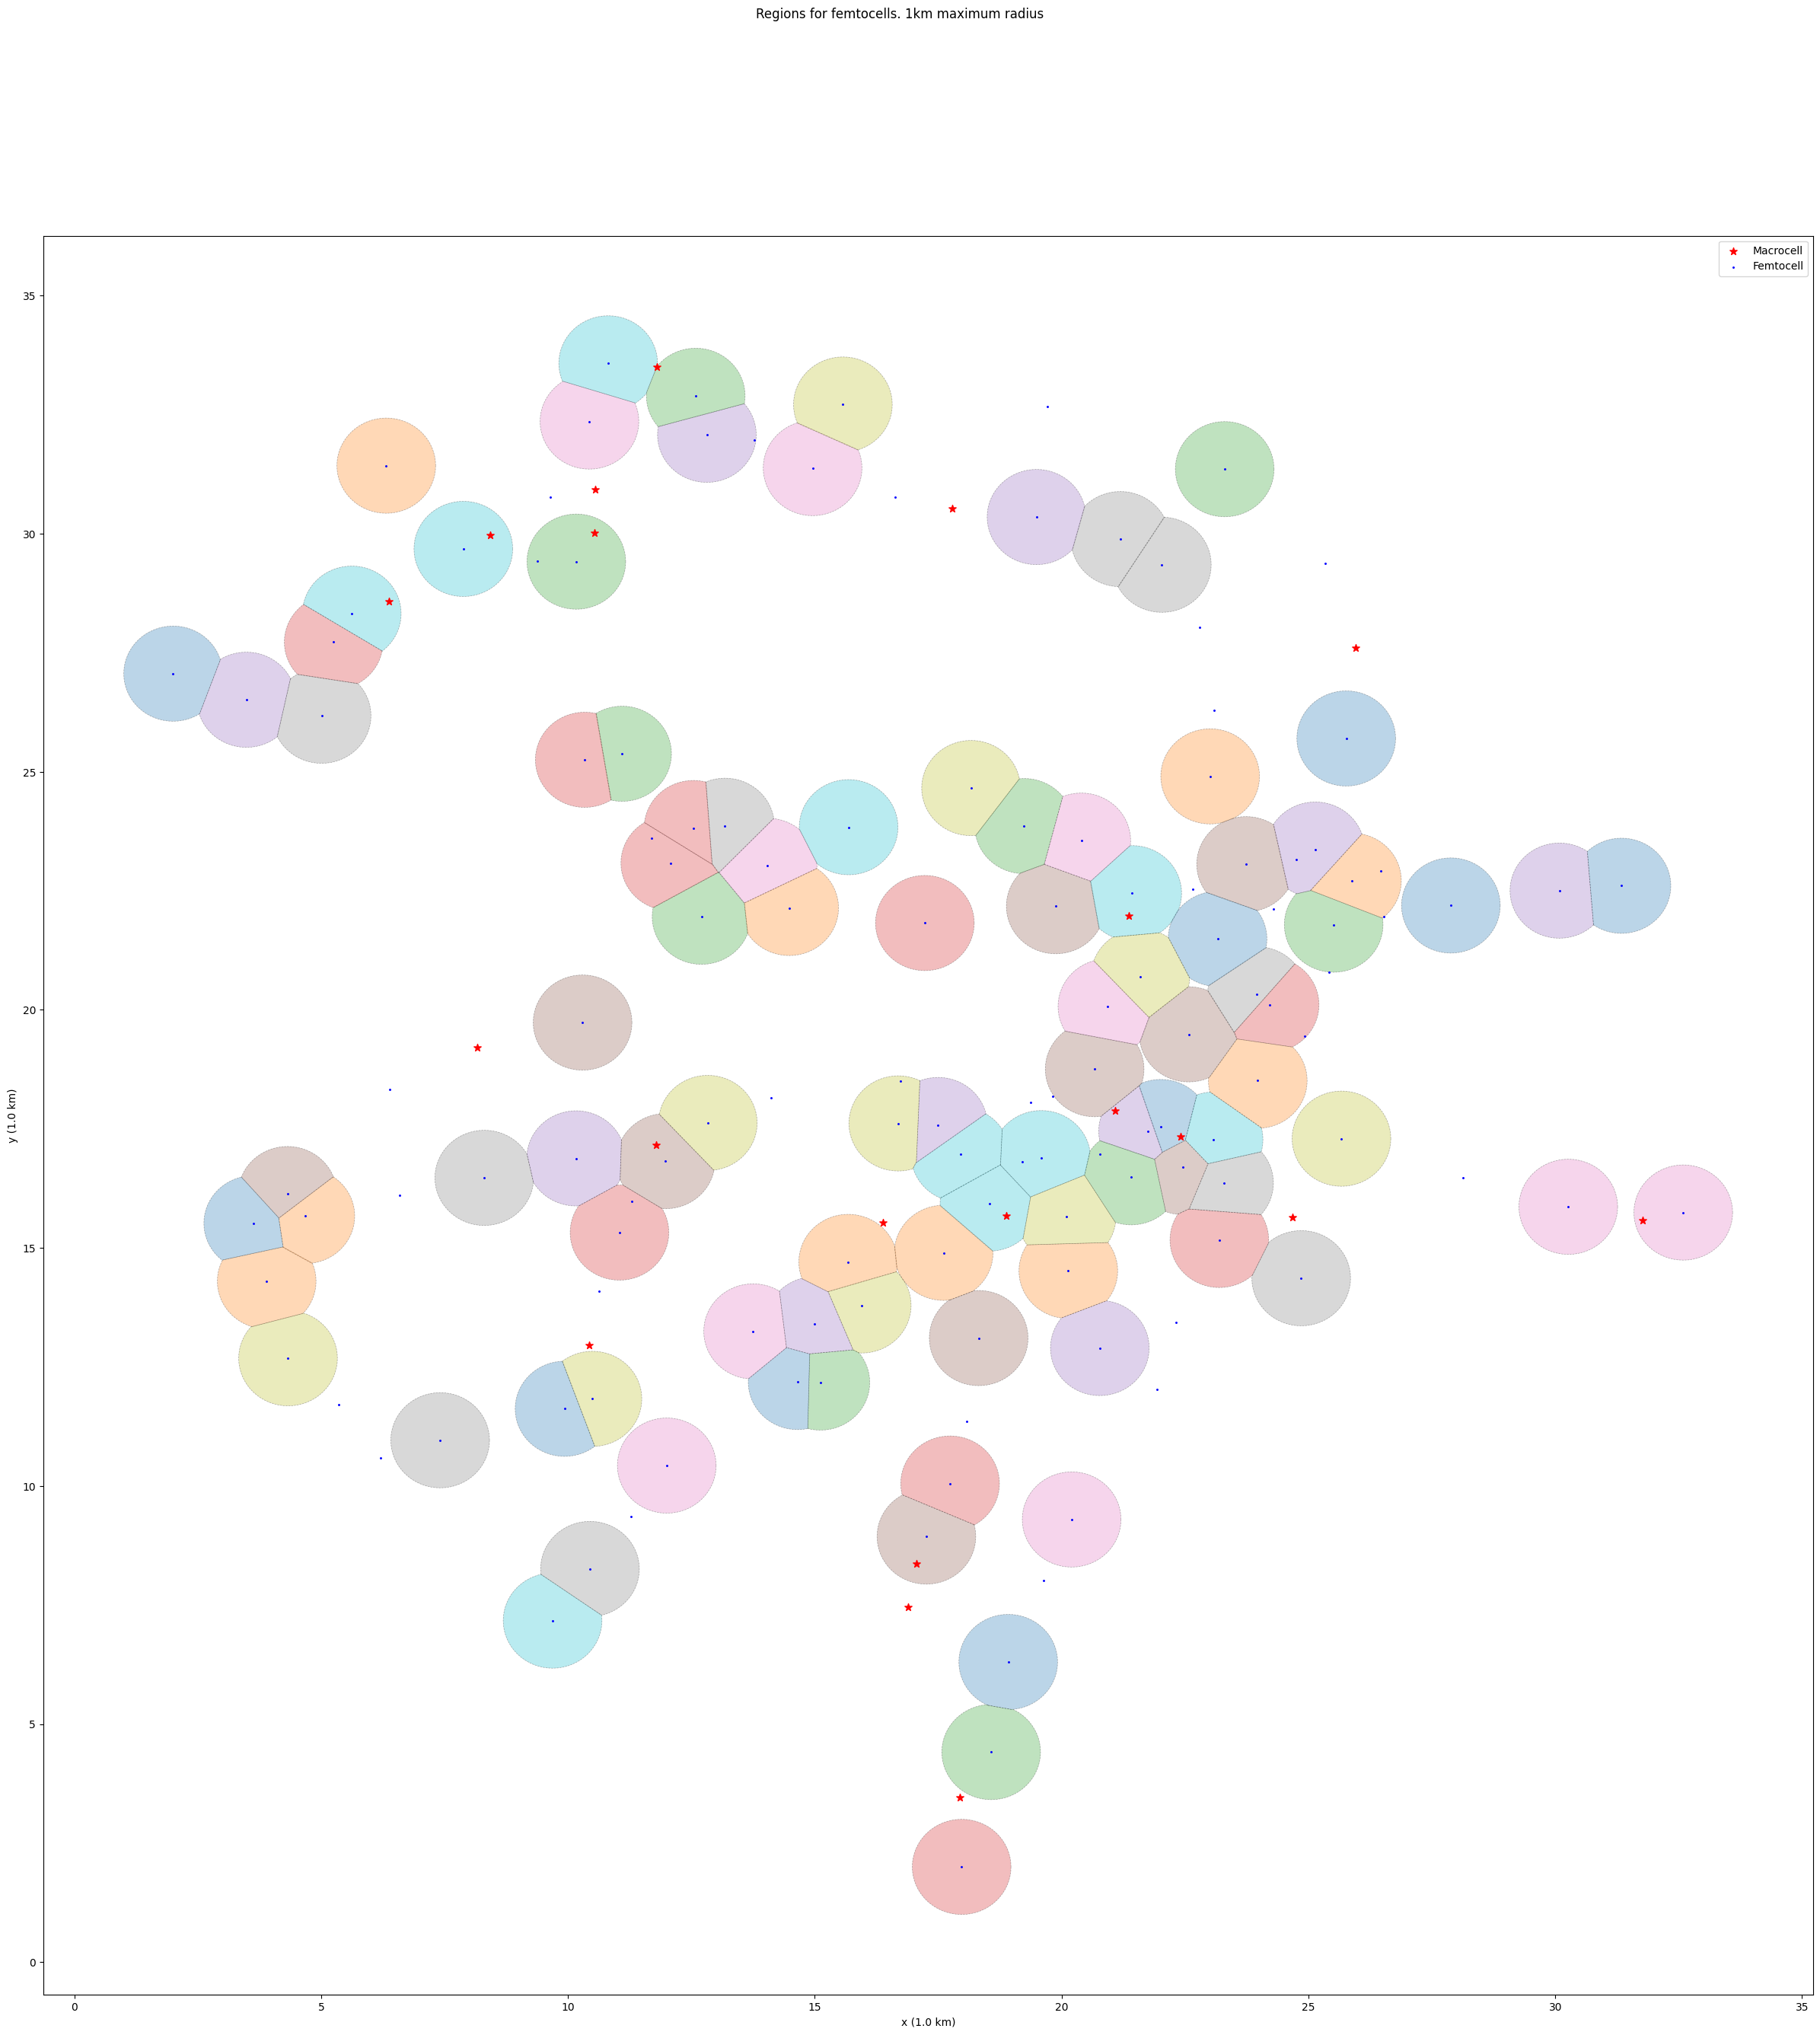

(<Figure size 3000x3000 with 1 Axes>,
 <Axes: xlabel='x (1.0 km)', ylabel='y (1.0 km)'>)

In [28]:
standard_plot(
    regions, 
    graph.nodes, 
    1.0, 
    femtocell_config={"marker": ".", "s": 5},
    plot_config={"title": "Regions for femtocells. 1km maximum radius", "figsize": (30, 30)},
)

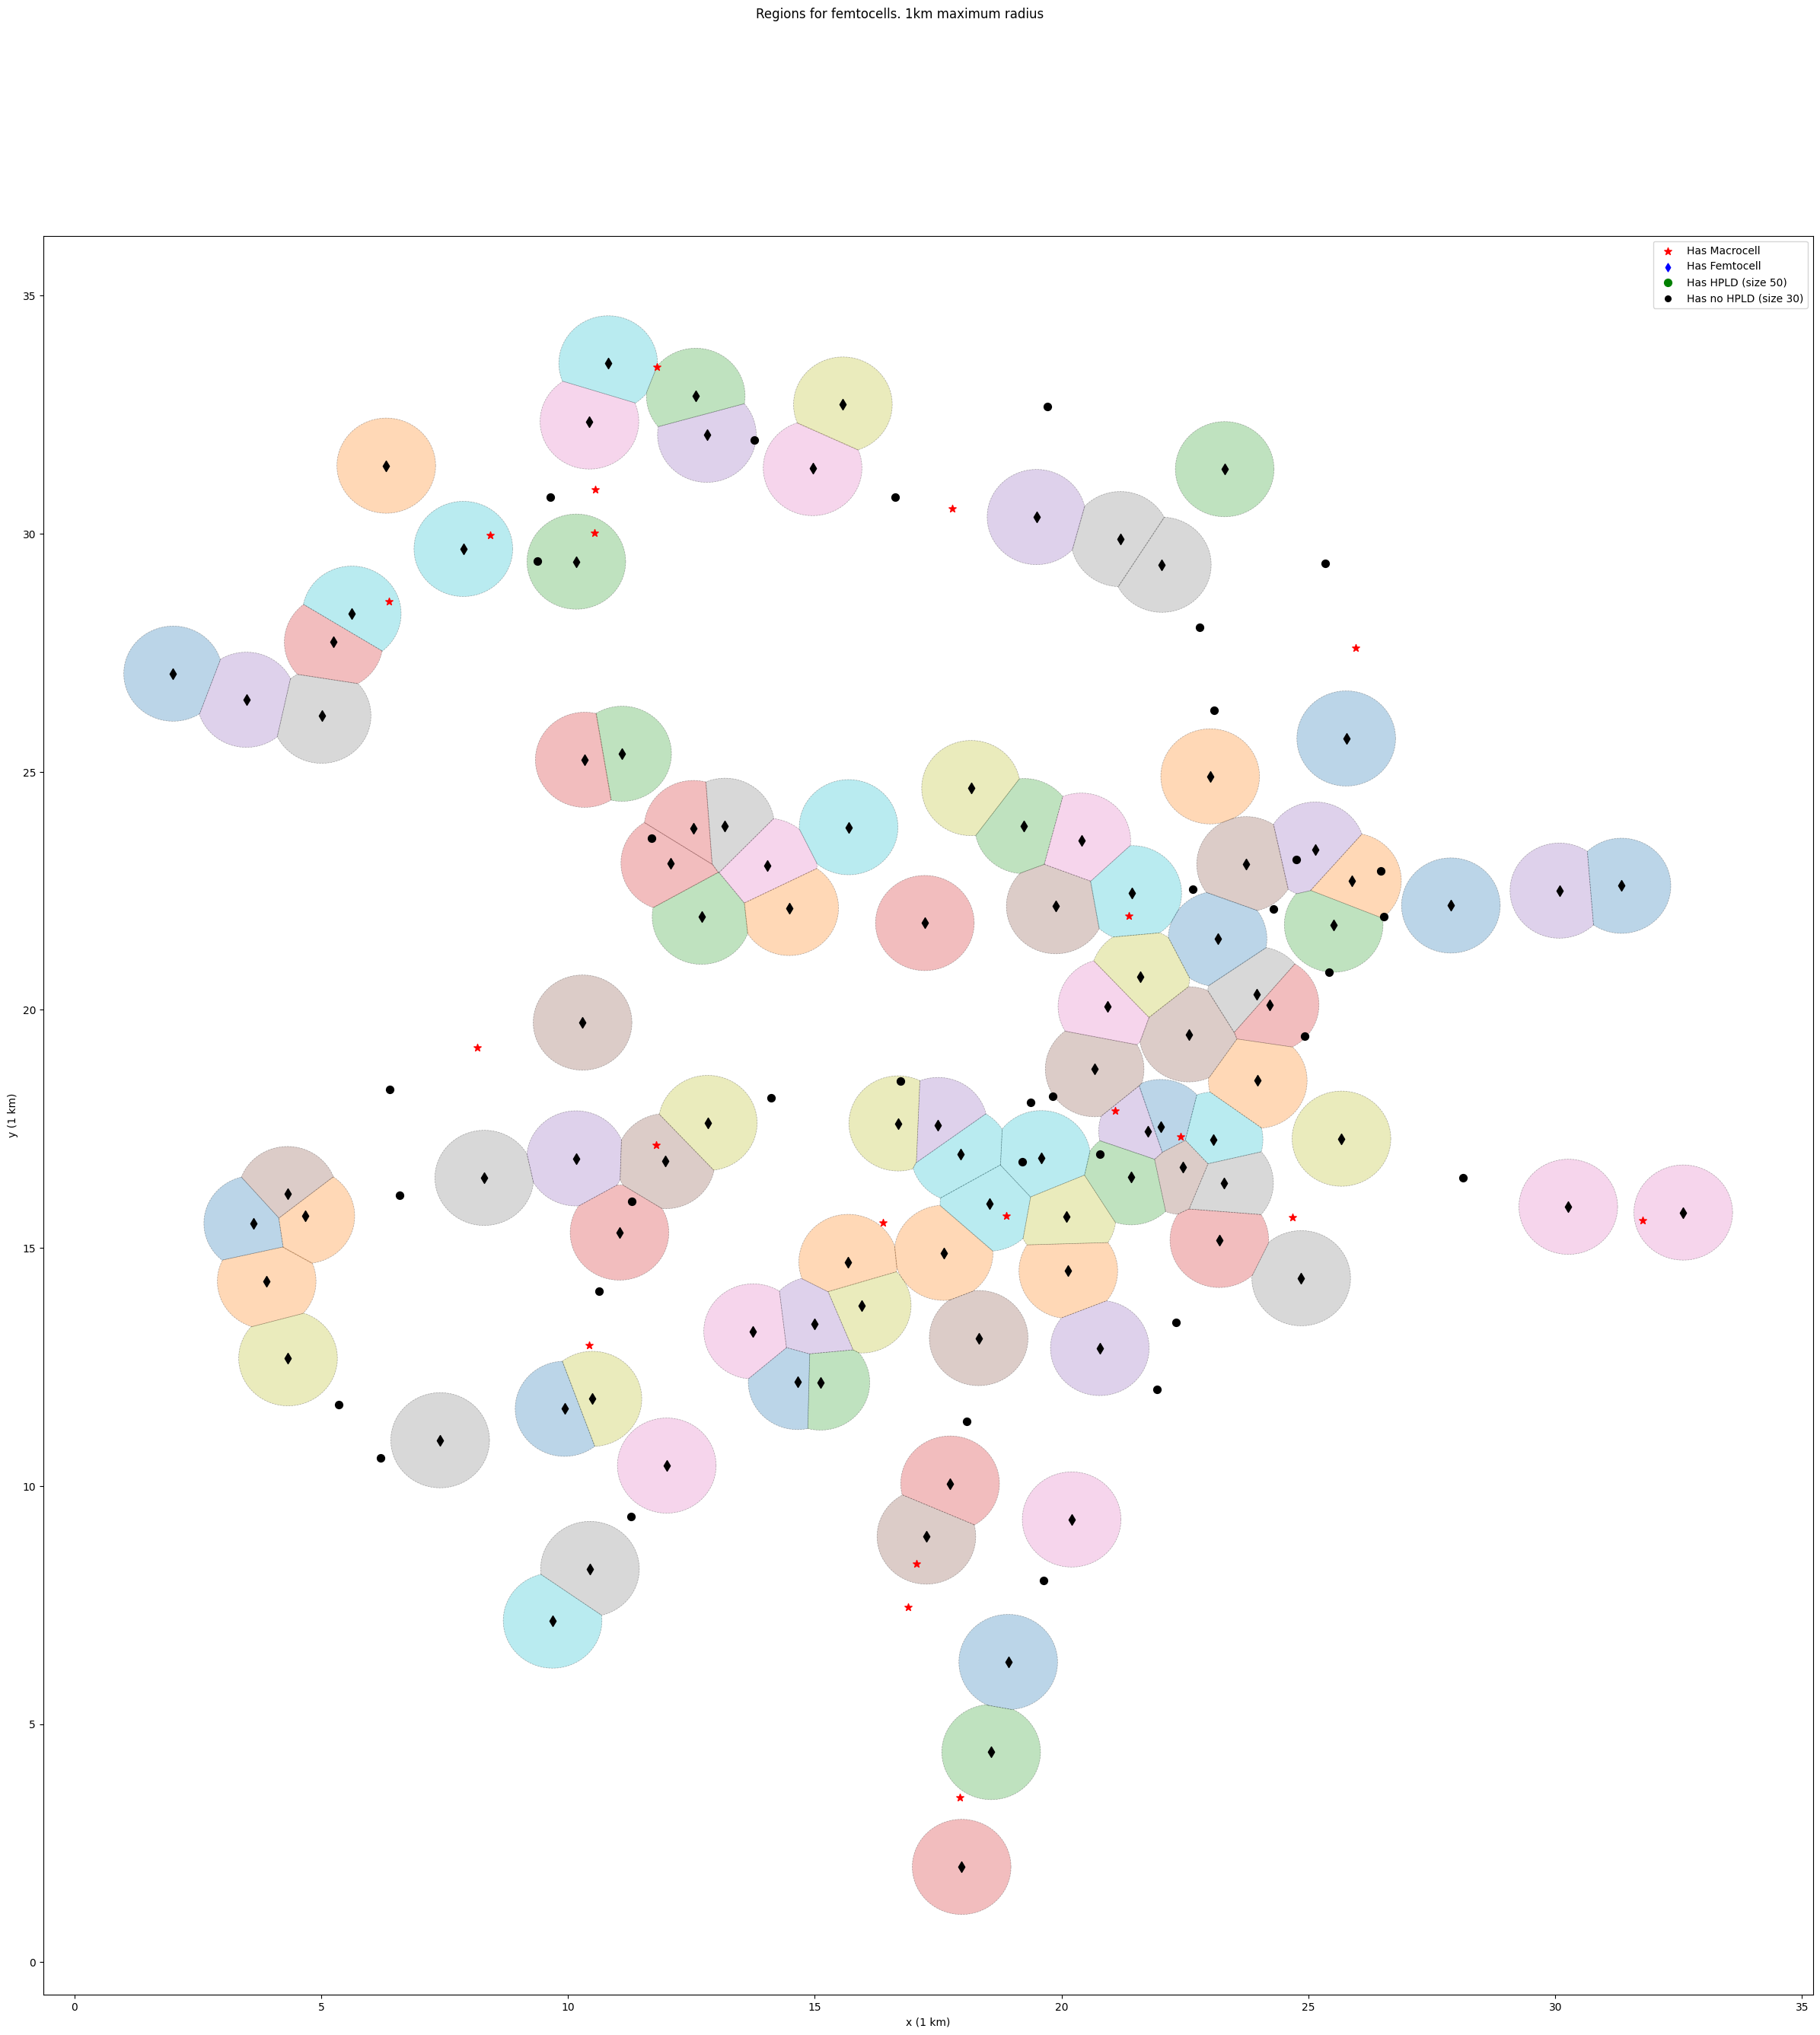

(<Figure size 3000x3000 with 1 Axes>,
 <Axes: xlabel='x (1 km)', ylabel='y (1 km)'>)

In [29]:
# (x, y, has_macrocell, has_femtocell, has_hpld)
nodes = [
    (node_positions[i][0], node_positions[i][1], node_type_hl4[i] == 1, nodes_with_femtocells[i] == 1, nodes_with_hpld[i] == 1)
    for i in range(num_nodes)
]

plot_algorithm_result(
    regions,
    nodes,
    plot_config={"title": "Regions for femtocells. 1km maximum radius", "figsize": (30, 30)},
)

In [30]:
print(f'Total HPLDs: {sum(nodes_with_hpld)}')
print(f'Total Femtocells: {sum(nodes_with_femtocells)}')
print(f'Deployed BW Capacity: {sum(nodes_with_femtocells)} Gbps')
print(f'Estimated Throughput: {sum(traffic_injection[nodes_with_femtocells == 1])/1000:.2f} Gbps')
print(f'Total Covered Area: {area.area - _unsold.area:.2f} ({(area.area - _unsold.area) / area.area * 100:.2f}%)')

Total HPLDs: 20
Total Femtocells: 100
Deployed BW Capacity: 100 Gbps
Estimated Throughput: 58.75 Gbps
Total Covered Area: 249.47 (20.27%)


In [31]:
from model.MatFileStorageParser import FileModel

In [44]:
BaseStations = []

# Add Macrocells
for node in range(len(node_positions)):
    if node_type_hl4[node] == 1:
        BaseStations.append((node_positions[node][0], node_positions[node][1], 40))

NMacroCells = len(BaseStations)
        
# Add Femtocells
for node in range(len(node_positions)):
    if nodes_with_femtocells[node] == 1:
        BaseStations.append((node_positions[node][0], node_positions[node][1], 0.1))
        
NFemtoCells = len(BaseStations) - NMacroCells


FileModel.save_file_basic("use_case_1.mat", BaseStations, NFemtoCells, NMacroCells)